## Necessary imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# To ignore warnings
import warnings
from pathlib import Path

import pandas as pd
import requests
import yaml
import yfinance as yf
from bs4 import BeautifulSoup

from utils.data import *

# from utils.data import (
#     clean_market_cap,
#     features_based_on_fundamentals,
#     features_based_on_price,
#     get_date_of_previous_month,
#     get_talib_momentum_indicators,
#     get_talib_pattern_indicators,
# )

warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Load configuration from YAML file
with open('../configs/external_indicators.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access indicators
fred_series = config['fred_series']
tickers_macro = config['tickers_macro']


# Verify the types
assert isinstance(fred_series, dict)
assert isinstance(tickers_macro, dict)

## Fetch table of tickers 

In [2]:
STOCKS_URL = "https://stockanalysis.com/list/nasdaq-100-stocks/"
START_DATE = '2020-01-01'
END_DATE = get_date_of_previous_month()

assert pd.to_datetime(END_DATE) < pd.to_datetime('today'), "END_DATE must be in the past"
assert pd.to_datetime(START_DATE) < pd.to_datetime(END_DATE), "START_DATE must be before END_DATE"

In [3]:
response = requests.get(STOCKS_URL)
soup = BeautifulSoup(response.text, "lxml")

table = soup.find('table')
rows = table.find_all('tr')

# Make sure to call find_all on the first row only for headers
headers = [th.text.strip() for th in rows[0].find_all('th')]
data = []
for row in rows[1:]:
    cols = [td.text.strip() for td in row.find_all('td')]
    if cols:
        data.append(cols)

df = pd.DataFrame(data, columns=headers)
number_of_stocks = len(df)
print(f"**Number of stocks in the list: {number_of_stocks}\n\n")
print(df.head())

**Number of stocks in the list: 101


  No. Symbol           Company Name Market Cap Stock Price % Change  Revenue
0   1   NVDA     NVIDIA Corporation  4,461.72B      183.61    3.93%  165.22B
1   2   MSFT  Microsoft Corporation  3,823.99B      514.45   -0.67%  281.72B
2   3   AAPL             Apple Inc.  3,800.33B      256.08    4.31%  408.63B
3   4   GOOG          Alphabet Inc.  3,056.00B      252.88   -0.92%  371.40B
4   5  GOOGL          Alphabet Inc.  3,054.10B      252.53   -0.86%  371.40B


In [4]:
# Clean 'Market Cap' column and convert to numeric
df = clean_market_cap(df)

In [5]:
# select the top 24 stocks by Market Cap (it is alreasdy sorted by volume on the website,
# but let's be sure in case that changes in the future)

df.sort_values(by='Market Cap', ascending=False, inplace=True)
top_24_by_volume = df.head(24)

print(top_24_by_volume[['Symbol', 'Company Name', 'Market Cap']])

   Symbol                  Company Name  Market Cap
0    NVDA            NVIDIA Corporation     4461.72
1    MSFT         Microsoft Corporation     3823.99
2    AAPL                    Apple Inc.     3800.33
3    GOOG                 Alphabet Inc.     3056.00
4   GOOGL                 Alphabet Inc.     3054.10
5    AMZN              Amazon.com, Inc.     2427.65
6    META          Meta Platforms, Inc.     1922.19
7    AVGO                 Broadcom Inc.     1599.89
8    TSLA                   Tesla, Inc.     1443.81
9    NFLX                 Netflix, Inc.      521.54
10   PLTR    Palantir Technologies Inc.      425.43
11   COST  Costco Wholesale Corporation      418.31
12   ASML             ASML Holding N.V.      369.58
13   CSCO           Cisco Systems, Inc.      267.83
14   TMUS             T-Mobile US, Inc.      267.22
15    AMD  Advanced Micro Devices, Inc.      259.31
16    AZN               AstraZeneca PLC      240.79
17    LIN                     Linde plc      224.03
18    APP   

In [6]:
top_24_by_volume

,No.,Symbol,Company Name,Market Cap,Stock Price,% Change,Revenue
0,1,NVDA,NVIDIA Corporation,4461.72,183.61,3.93%,165.22B
1,2,MSFT,Microsoft Corporation,3823.99,514.45,-0.67%,281.72B
2,3,AAPL,Apple Inc.,3800.33,256.08,4.31%,408.63B
3,4,GOOG,Alphabet Inc.,3056.00,252.88,-0.92%,371.40B
4,5,GOOGL,Alphabet Inc.,3054.10,252.53,-0.86%,371.40B
5,6,AMZN,"Amazon.com, Inc.",2427.65,227.63,-1.66%,670.04B
6,7,META,"Meta Platforms, Inc.",1922.19,765.16,-1.57%,178.80B
7,8,AVGO,Broadcom Inc.,1599.89,338.79,-1.45%,59.93B
8,9,TSLA,"Tesla, Inc.",1443.81,434.21,1.91%,92.72B
9,10,NFLX,"Netflix, Inc.",521.54,"1,227.37",0.03%,41.69B


In [7]:
tickers_list =  top_24_by_volume['Symbol'].tolist()
tickers_list

['NVDA',
 'MSFT',
 'AAPL',
 'GOOG',
 'GOOGL',
 'AMZN',
 'META',
 'AVGO',
 'TSLA',
 'NFLX',
 'PLTR',
 'COST',
 'ASML',
 'CSCO',
 'TMUS',
 'AMD',
 'AZN',
 'LIN',
 'APP',
 'SHOP',
 'INTU',
 'PEP',
 'MU',
 'PDD']

## Feature engineering

### Price data

In [8]:
%%time 

ticker_data = dict()
dataset_price = dict()
dataset_price_df = pd.DataFrame()

for i,ticker in enumerate(tickers_list):

  print(f"{i} - Fetching data for {ticker} stock...\n")
  print("-"*24, "\n")
  
  ticker_data[ticker] = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE, interval='1d')
  price_data_by_ticker = features_based_on_price(ticker_data[ticker], ticker=ticker)
  print("-"*24, "\n")
  
  dataset_price_df = pd.concat([dataset_price_df, price_data_by_ticker], axis=0)
  dataset_price[ticker] = price_data_by_ticker
  
  # For testing, limit to first ticker only
  # if i == 1:
  #   break

0 - Fetching data for NVDA stock...

------------------------ 

'Adj Close' not present in columns for NVDA.Using 'Close' instead.
Data columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Data index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data shape:  (1423, 7)
Resampling to month-end frequency... 

Resampling done. The new data shape is  (68, 22)
Final data shape for NVDA:  (63, 33)
------------------------ 

1 - Fetching data for MSFT stock...

------------------------ 

'Adj Close' not present in columns for MSFT.Using 'Close' instead.
Data columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Data index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data shape:  (1423, 7)
Resampling to month-end frequency... 

Resampling done. The new data shape is  (68, 22)
Final data shape for MSFT:  (63, 33)
------------------------ 

2 - Fetching data for AA

In [9]:
dataset_price_df.ticker.value_counts()

ticker
NVDA     63
MSFT     63
MU       63
PEP      63
INTU     63
SHOP     63
LIN      63
AZN      63
AMD      63
TMUS     63
CSCO     63
ASML     63
COST     63
NFLX     63
TSLA     63
AVGO     63
META     63
AMZN     63
GOOGL    63
GOOG     63
AAPL     63
PDD      63
PLTR     55
APP      48
Name: count, dtype: int64

In [10]:
dataset_price_df.iloc[-1]

Date                      2025-08-31 00:00:00
Close                              120.220001
ln_volume_min                       14.972989
ln_volume_median                    15.717155
ln_volume_max                        17.25932
daily_growth_min                    -0.033539
daily_growth_median                  0.001718
daily_growth_max                     0.042034
weekly_growth_min                   -0.070832
weekly_growth_median                 0.022675
weekly_growth_max                    0.083404
biweekly_growth_min                 -0.038156
biweekly_growth_median               0.032855
biweekly_growth_max                    0.1342
monthly_growth_min                    0.02573
monthly_growth_median                0.077495
monthly_growth_max                   0.136901
rel_spread_oc_median                 0.000736
rel_spread_hl_median                 0.025942
vol_10d_mean_median                  0.003354
vol_10d_std_median                   0.017889
vol_10d_min_median                

### Fundamental features

In [11]:
%%time 

dataset_fundamentals = dict()

for i,ticker in enumerate(tickers_list):

    print(f"{i} - Fetching data for {ticker} stock...\n")
    print("-"*24, "\n")

    dataset_fundamentals[ticker] = features_based_on_fundamentals(ticker, END_DATE)

    print("-"*24, "\n")

    # For testing, limit to first ticker only
    # if i == 1:
    #     break

0 - Fetching data for NVDA stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

1 - Fetching data for MSFT stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

2 - Fetching data for AAPL stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

3 - Fetching data for GOOG stock...

------------------------ 



HTTP Error 404: 


Number of missing values in fund_feats_float: 3
------------------------ 

4 - Fetching data for GOOGL stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

5 - Fetching data for AMZN stock...

------------------------ 

Number of missing values in fund_feats_float: 2
------------------------ 

6 - Fetching data for META stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

7 - Fetching data for AVGO stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

8 - Fetching data for TSLA stock...

------------------------ 

Number of missing values in fund_feats_float: 2
------------------------ 

9 - Fetching data for NFLX stock...

------------------------ 

Number of missing values in fund_feats_float: 2
------------------------ 

10 - Fetching data for PLTR stock...

------------------------ 

Number of missing values 

HTTP Error 404: 


Number of missing values in fund_feats_float: 3
------------------------ 

13 - Fetching data for CSCO stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

14 - Fetching data for TMUS stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

15 - Fetching data for AMD stock...

------------------------ 

Number of missing values in fund_feats_float: 2
------------------------ 

16 - Fetching data for AZN stock...

------------------------ 



HTTP Error 404: 


Number of missing values in fund_feats_float: 3
------------------------ 

17 - Fetching data for LIN stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

18 - Fetching data for APP stock...

------------------------ 

Number of missing values in fund_feats_float: 2
------------------------ 

19 - Fetching data for SHOP stock...

------------------------ 

Number of missing values in fund_feats_float: 3
------------------------ 

20 - Fetching data for INTU stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

21 - Fetching data for PEP stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

22 - Fetching data for MU stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

23 - Fetching data for PDD stock...

------------------------ 

Number of missing values i

### TALIB-based indicators

In [12]:
%%time 

dataset_talib_pattern = dict()
dataset_talib_momentum = dict()

for i,ticker in enumerate(tickers_list):

    print(f"{i} - Calculate TALIB-based fearures for {ticker} stock...\n")
    print("-"*24, "\n")

    data_with_date = ticker_data[ticker].reset_index()
    data_with_date_ticker = data_with_date.copy()
    data_with_date_ticker['Ticker'] = ticker

    rows_initial = len(data_with_date_ticker)
    
    # Ensure columns are float64 before passing to TA-Lib
    # That part should resolve the issue with the `mfi` indicator, but it did not
    # TODO: investigate further if needed
    for col in ['Open', 'High', 'Low', 'Close']:
        data_with_date_ticker[col] = pd.to_numeric(data_with_date_ticker[col], errors='coerce')

    rows_after_conversion = len(data_with_date_ticker.dropna(subset=['Open', 'High', 'Low', 'Close']))
    
    if rows_initial != rows_after_conversion:
        print(f"Warning: Number of rows changed after numeric conversion for {ticker} stock: {rows_initial} -> {rows_after_conversion}")
    
    dataset_talib_pattern[ticker] = get_talib_pattern_indicators(data_with_date_ticker)
    print("# of pattern indicators calculated:", len(dataset_talib_pattern[ticker].columns))
    
    dataset_talib_momentum[ticker] = get_talib_momentum_indicators(data_with_date_ticker)
    print("# of momentum indicators calculated:", len(dataset_talib_momentum[ticker].columns))

    zeros_pattern, zeros_momentum = (dataset_talib_pattern[ticker] == 0).sum().sum(),\
                                        (dataset_talib_momentum[ticker] == 0).sum().sum()
    print(f"% of zeros in pattern indicators: {zeros_pattern /  (dataset_talib_pattern[ticker].shape[0]*dataset_talib_pattern[ticker].shape[1]):.2%} ")
    print(f"% of zeros in momentum indicators: {zeros_momentum / (dataset_talib_momentum[ticker].shape[0]*dataset_talib_momentum[ticker].shape[1]):.2%} ")

    print("-"*24, "\n")

    # For testing, limit to first ticker only
    # if i == 1:
    #     break

0 - Calculate TALIB-based fearures for NVDA stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indicators: 93.62% 
% of zeros in momentum indicators: 1.46% 
------------------------ 

1 - Calculate TALIB-based fearures for MSFT stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indicators: 93.60% 
% of zeros in momentum indicators: 1.40% 
------------------------ 

2 - Calculate TALIB-based fearures for AAPL stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indicators: 93.56% 
% of zeros in momentum indicators: 1.51% 
------------------------ 

3 - Calculate TALIB-based fearures for GOOG stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indic

### External indicators

#### Macro Economic Indicators (fred_series)

In [13]:
dataset_fred = get_economic_indicators_fred(
    fred_mapping=fred_series, start_date=START_DATE, end_date=END_DATE)

dataset_fred

Retrieve fred series for the selected period...



,Date,gdp_us,cpi_us,unemployment_us,interest_us,gdp_de,cpi_de,interest_eu
0,2020-01-31,20693.238,259.127,3.6,1.55,748188.8,105.2175,0.315867
1,2020-02-29,20693.238,259.250,3.5,1.58,748188.8,105.5338,0.132263
2,2020-03-31,20693.238,258.076,4.4,0.65,748188.8,105.7447,0.372634
3,2020-04-30,19056.617,256.032,14.8,0.05,681793.6,105.8501,0.553776
4,2020-05-31,19056.617,255.802,13.2,0.05,681793.6,105.8501,0.479136
...,...,...,...,...,...,...,...,...
63,2025-04-30,23703.782,320.321,4.2,4.33,764275.7,127.7792,3.097221
64,2025-05-31,23703.782,320.580,4.2,4.33,764275.7,127.7792,3.070995
65,2025-06-30,23703.782,321.500,4.1,4.33,764275.7,127.7792,3.084761
66,2025-07-31,23703.782,322.132,4.2,4.33,764275.7,127.7792,3.173563


#### Major indices

In [14]:
dataset_major_indices = get_macro_market_data(
    tickers_macro=tickers_macro, start_date=START_DATE, end_date=END_DATE)

dataset_major_indices

Retrieve major tickers for the selected period...



,Date,sp500,vix,dax,spy,gld,vgk,xlv,xlk,xlf,efa,eurusd,usdx
0,2020-01-31,3225.520020,18.840000,12981.969727,295.692780,149.330002,47.198620,90.355179,90.678375,26.877407,57.435558,1.102913,97.389999
1,2020-02-29,2954.219971,40.110001,11890.349609,272.284058,148.380005,43.442013,84.403824,84.058006,23.854156,52.975536,1.099723,98.129997
2,2020-03-31,2584.590088,53.540001,9935.839844,238.283600,148.050003,36.207626,81.122749,76.847549,18.836206,45.502445,1.103047,99.050003
3,2020-04-30,2912.429932,34.150002,10861.639648,268.541718,158.800003,38.541706,91.334045,87.403694,20.618502,48.149517,1.087725,99.019997
4,2020-05-31,3044.310059,27.510000,11586.849609,281.336426,162.910004,40.792133,94.337921,93.676178,21.179426,50.762550,1.107911,98.339996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2025-04-30,5569.060059,24.700001,22496.980469,551.376831,303.769989,71.664345,139.166168,209.353531,48.434021,83.307266,1.138926,99.470001
64,2025-05-31,5911.689941,18.570000,23997.480469,586.028015,303.600006,75.448563,131.408844,230.232040,50.619316,87.298149,1.137838,99.330002
65,2025-06-30,6204.950195,16.730000,23909.609375,616.141785,304.829987,77.296791,134.176376,252.904968,52.198166,89.389999,1.172745,96.879997
66,2025-07-31,6339.390137,16.719999,24065.470703,630.332458,302.959991,75.451645,129.836227,262.402771,52.198166,87.519997,1.142936,100.029999


## Final dataset creation by merging separate dataframes

In [15]:
# use this cell for one ticker only
ticker = "MSFT"

try:
    ticker_data = dataset_price[ticker]

    # Add fundamentals data to the price data (row by row)
    for k, v in dataset_fundamentals[ticker].items():
        ticker_data[k] = v

    # Resample talib data to monthly end frequency and take median
    df1 = dataset_talib_momentum[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()
    df2 = dataset_talib_pattern[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()

    # Merge ticker_data with df1 on 'Date'
    merged1 = pd.merge(ticker_data, df1, how='left', on='Date', validate='many_to_one')

    # Merge the result with df2 on 'Date'
    merged2 = pd.merge(merged1, df2, how='left', on='Date', validate='many_to_one')

    # Merge with dataset_fred on 'Date'
    merged3 = pd.merge(merged2, dataset_fred, how='left', on='Date', validate='many_to_one')

    # Final merge with dataset_major_indices
    final_merged = pd.merge(merged3, dataset_major_indices, how='left', on='Date', validate='many_to_one')

    # final_merged now contains columns from all three DataFrames, joined on 'Date'
    print(final_merged.shape)

except KeyError:
    final_merged = pd.DataFrame()
    raise KeyError(f"Ticker {ticker} not found in dataset_price")

(63, 181)


In [16]:
# Ensure sorted by date
final_merged = final_merged.sort_values('Date')  

# Create TARGET column as the close price shifted by -3 months (3 months ahead)
final_merged['TARGET'] = final_merged['Close'].shift(-3)

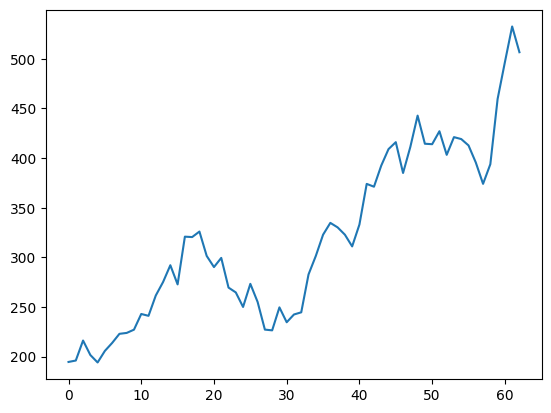

In [17]:
final_merged.Close.plot();

In [18]:
final_merged.isnull().sum().sum()

np.int64(3)

In [19]:
final_merged[['Close', 'TARGET', 'return_3m']].head(10)

,Close,TARGET,return_3m
0,194.660004,201.669739,0.294000
1,196.094772,194.133408,0.147151
2,216.243881,205.793106,0.233698
3,201.669739,213.820251,0.036010
4,194.133408,222.991455,-0.010002
5,205.793106,223.909698,-0.048329
6,213.820251,227.176147,0.060250
7,222.991455,242.987946,0.148651
8,223.909698,241.134644,0.088033
9,227.176147,261.628418,0.062463


## Wrap dataset creation for all provided tickers

In [20]:
full_dataset = pd.DataFrame()

for i, ticker in enumerate(tickers_list):

    print(f"{i} - Processing data for {ticker} stock...\n")
    print("-"*24, "\n")

    try:
        ticker_data = dataset_price[ticker]

        # Add fundamentals data to the price data (row by row)
        for k, v in dataset_fundamentals[ticker].items():
            ticker_data[k] = v

        # Resample talib data to monthly end frequency and take median
        df1 = dataset_talib_momentum[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()
        df2 = dataset_talib_pattern[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()

        # Merge ticker_data with df1 on 'Date'
        merged1 = pd.merge(ticker_data, df1, how='left', on='Date', validate='many_to_one')

        # Merge the result with df2 on 'Date'
        merged2 = pd.merge(merged1, df2, how='left', on='Date', validate='many_to_one')

        # Merge with dataset_fred on 'Date'
        merged3 = pd.merge(merged2, dataset_fred, how='left', on='Date', validate='many_to_one')

        # Final merge with dataset_major_indices
        final_merged = pd.merge(merged3, dataset_major_indices, how='left', on='Date', validate='many_to_one')

        # final_merged now contains columns from all three DataFrames, joined on 'Date'
        print(final_merged.shape)

        # Ensure sorted by date
        final_merged = final_merged.sort_values('Date')
        # Create TARGET column as the close price shifted by -3 months (3 months ahead)
        final_merged['TARGET'] = final_merged['Close'].shift(-3)
        # Drop rows with NaN in TARGET
        final_merged = final_merged.dropna(subset=['TARGET'])

        # Append to full_dataset
        full_dataset = pd.concat([full_dataset, final_merged], axis=0)

        print("-"*24, "\n")


    except KeyError:
        print(f"\n\nTicker {ticker} not found in dataset_price\n\n")
        continue

0 - Processing data for NVDA stock...

------------------------ 

(63, 181)
------------------------ 

1 - Processing data for MSFT stock...

------------------------ 

(63, 181)
------------------------ 

2 - Processing data for AAPL stock...

------------------------ 

(63, 181)
------------------------ 

3 - Processing data for GOOG stock...

------------------------ 

(63, 181)
------------------------ 

4 - Processing data for GOOGL stock...

------------------------ 

(63, 181)
------------------------ 

5 - Processing data for AMZN stock...

------------------------ 

(63, 181)
------------------------ 

6 - Processing data for META stock...

------------------------ 

(63, 181)
------------------------ 

7 - Processing data for AVGO stock...

------------------------ 

(63, 181)
------------------------ 

8 - Processing data for TSLA stock...

------------------------ 

(63, 181)
------------------------ 

9 - Processing data for NFLX stock...

------------------------ 

(63, 1

In [21]:
full_dataset.shape

(1417, 182)

## Minimal data observation

In [22]:
full_dataset.ticker.value_counts()

ticker
NVDA     60
MSFT     60
MU       60
PEP      60
INTU     60
SHOP     60
LIN      60
AZN      60
AMD      60
TMUS     60
CSCO     60
ASML     60
COST     60
NFLX     60
TSLA     60
AVGO     60
META     60
AMZN     60
GOOGL    60
GOOG     60
AAPL     60
PDD      60
PLTR     52
APP      45
Name: count, dtype: int64

In [23]:
columns_with_nan = full_dataset.columns[full_dataset.isnull().any()].tolist()
print(columns_with_nan)

['trailing_PEG', 'dividendYield', 'esg_env', 'esg_soc', 'esg_gov', 'days_to_next_earnings', 'dividend_stability']


In [24]:
full_dataset[columns_with_nan].isnull().sum().index

Index(['trailing_PEG', 'dividendYield', 'esg_env', 'esg_soc', 'esg_gov',
       'days_to_next_earnings', 'dividend_stability'],
      dtype='object')

In [25]:
# Replace 'column_name' with the name of the column you want to check for NaN values
rows_with_nans = full_dataset[full_dataset[columns_with_nan[2]].isna()]
rows_with_nans[['ticker', columns_with_nan[2]]]

,ticker,esg_env
0,GOOG,NaN
1,GOOG,NaN
2,GOOG,NaN
3,GOOG,NaN
4,GOOG,NaN
...,...,...
55,AZN,NaN
56,AZN,NaN
57,AZN,NaN
58,AZN,NaN


In [26]:
full_dataset[[columns_with_nan[2]]].value_counts()

esg_env
0.16       60
3.68       60
8.85       60
8.54       60
8.46       60
8.12       60
7.84       60
7.50       60
3.87       60
3.40       60
3.29       60
3.04       60
3.01       60
2.47       60
2.33       60
1.75       60
1.32       60
1.12       60
11.05      60
5.69       52
0.39       45
Name: count, dtype: int64

In [27]:
full_dataset[columns_with_nan].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1417 entries, 0 to 59
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trailing_PEG           1357 non-null   float64
 1   dividendYield          960 non-null    float64
 2   esg_env                1237 non-null   float64
 3   esg_soc                1237 non-null   float64
 4   esg_gov                1237 non-null   float64
 5   days_to_next_earnings  1357 non-null   float64
 6   dividend_stability     960 non-null    float64
dtypes: float64(7)
memory usage: 88.6 KB


In [28]:
# List of different kinds of variables in full_dataset
date_variables = ['Date']
target_variables = ['TARGET']
price_variables = ['Close', 'return_1m', 'return_2m', 'return_3m']
volume_variables = ['ln_volume_min', 'ln_volume_median', 'ln_volume_max', 'vol_10d_mean_median', 'vol_10d_std_median', 'vol_10d_min_median', 'vol_10d_max_median', 'vol_3m']
growth_variables = ['daily_growth_min', 'daily_growth_median', 'daily_growth_max', 'weekly_growth_min', 'weekly_growth_median', 'weekly_growth_max', 'biweekly_growth_min', 'biweekly_growth_median', 'biweekly_growth_max', 'monthly_growth_min', 'monthly_growth_median', 'monthly_growth_max']
momentum_variables = ['momentum_3m', 'mma_3_scaled', 'mma_6_scaled']
fundamental_variables = ['marketCap', 'beta', 'trailingPE', 'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield', 'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital', 'working_capital_ratio', 'retained_earnings_to_assets', 'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin', 'pct_held_by_inst', 'institutional_holders_count']
esg_variables = ['esg_env', 'esg_soc', 'esg_gov']
rating_variables = ['recent_rating_changes', 'strong_to_total_reco_ratio']
earnings_variables = ['days_to_next_earnings', 'dividend_stability']
categorical_variables = ['ticker', 'companyName', 'sector', 'industry', 'country']
other_variables = ['year', 'month', 'fullTimeEmployees']

all_variables = date_variables + target_variables + price_variables + volume_variables + growth_variables + momentum_variables + fundamental_variables + esg_variables + rating_variables + earnings_variables + categorical_variables + other_variables

for _ in all_variables:
    assert _ in full_dataset.columns, f"{_} not in full_dataset"

In [29]:
len(set(full_dataset.columns))

182

In [30]:
full_dataset.shape

(1417, 182)

In [31]:
# Detect numerical columns
numerical_columns = full_dataset.select_dtypes(include=['number']).columns.tolist()

# Detect categorical columns
categorical_columns = full_dataset.select_dtypes(include=['object']).columns.tolist()

# Detect datetime columns
datetime_columns = full_dataset.select_dtypes(include=['datetime']).columns.tolist()

print("Numerical Columns:", numerical_columns, "\n", len(numerical_columns))
print("Categorical Columns:", categorical_columns, "\n", len(categorical_columns))
print("Datetime Columns:", datetime_columns, "\n", len(datetime_columns))

Numerical Columns: ['Close', 'ln_volume_min', 'ln_volume_median', 'ln_volume_max', 'daily_growth_min', 'daily_growth_median', 'daily_growth_max', 'weekly_growth_min', 'weekly_growth_median', 'weekly_growth_max', 'biweekly_growth_min', 'biweekly_growth_median', 'biweekly_growth_max', 'monthly_growth_min', 'monthly_growth_median', 'monthly_growth_max', 'rel_spread_oc_median', 'rel_spread_hl_median', 'vol_10d_mean_median', 'vol_10d_std_median', 'vol_10d_min_median', 'vol_10d_max_median', 'return_1m', 'return_2m', 'return_3m', 'vol_3m', 'momentum_3m', 'mma_3_scaled', 'mma_6_scaled', 'year', 'month', 'marketCap', 'beta', 'trailingPE', 'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield', 'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital', 'working_capital_ratio', 'retained_earnings_to_assets', 'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin', 'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc', 'esg_gov', 'recent_rating_changes',

In [32]:
full_dataset.sector.value_counts()

sector
Technology                652
Communication Services    345
Consumer Cyclical         180
Consumer Defensive        120
Healthcare                 60
Basic Materials            60
Name: count, dtype: int64

In [33]:
full_dataset.industry.value_counts()

industry
Semiconductors                         240
Internet Content & Information         180
Internet Retail                        120
Software - Application                 120
Software - Infrastructure              112
Consumer Electronics                    60
Auto Manufacturers                      60
Entertainment                           60
Discount Stores                         60
Semiconductor Equipment & Materials     60
Communication Equipment                 60
Telecom Services                        60
Drug Manufacturers - General            60
Specialty Chemicals                     60
Beverages - Non-Alcoholic               60
Advertising Agencies                    45
Name: count, dtype: int64

In [34]:
full_dataset.country.value_counts()

country
United States     1117
United Kingdom     120
Netherlands         60
Canada              60
Ireland             60
Name: count, dtype: int64

## Store data

In [35]:
# Define the folder path
notebook_dir = Path().resolve()

# Check if the 'data' folder exists, if not, create it
data_dir = notebook_dir.parent / 'data'
data_dir.mkdir(exist_ok=True)

# Define the file path for the CSV
data_path = data_dir / 'full_dataset.csv'

# Save the full_dataset as a CSV file
full_dataset.to_csv(data_path, index=False)

print(f"Dataset saved to {data_path.relative_to(notebook_dir.parent.parent)}")

Dataset saved to stock-markets-analytics-zoomcamp-project-by-sk/data/full_dataset.csv


In [36]:
print("That's all, folks!")

That's all, folks!
